# Transfer Learning

## 1. Feature Extraction

In [2]:
from tensorflow.keras.applications import VGG16

# Pretrained Network 생성
model_base = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

model_base.summary() # Activation Map: (None, 4, 4, 512)

58892288/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [3]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = '/content/drive/MyDrive/ML Colab/data/CAT_DOG/cat_dog_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# ImageDataGenerator 객체 생성 (데이터 정규화 및 증식 포함)
datagen = ImageDataGenerator(rescale=1/255)

# 배치 사이즈 설정 (ImageDataGenerator 무한 생성 방지용)
batch_size = 20

# Activation Map 추출 함수 
def extract_feature(directory, sample_count): 
    # X: sample_count 수만큼 입력으로 들어가는 이미지에 대한 Feature Map 저장공간
    features = np.zeros(shape=(sample_count, 4,4,512)) # 4차원 행렬

    # T: Feature Map에 대한 Label
    labels = np.zeros(shape=(sample_count,)) # 1차원 벡터

    # 이미지를 읽어들이는 ImageDataGenerator 최종본 생성
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,150), # input_shape과 연관
        batch_size=batch_size,
        class_mode='binary' 
    )

    i = 0
    for x_data_batch, t_data_batch in generator: # (X: 픽셀 데이터, T: label) 
        # Activation Map 도출 (batch_size개)
        feature_batch = model_base.predict(x_data_batch) 
        # Activation Map 추가
        features[i*batch_size:(i+1)*batch_size] = feature_batch
        # Label 추가
        labels[i*batch_size:(i+1)*batch_size] = t_data_batch

        i += 1
        if i*batch_size >= sample_count:
          break
                
    return features, labels

# Activation Map (4차원 데이터)
# DNN에 입력할 데이터 
train_features, train_labels = extract_feature(train_dir, 2000)
validation_features, validation_labels = extract_feature(validation_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Classifier

In [13]:
# 4차원 데이터(Activation Map)를 2차원 데이터로 변경
# Numpy Array
train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))

# FC Layer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop

# 모델 생성
model = Sequential()

# Hidden Layer
# input_shape: input layer용 (07:30~08:00)
model.add(Dense(256, activation='relu', input_shape=(4*4*512,)))

# Dropout Layer
model.add(Dropout(0.5))

# Output Layer
model.add(Dense(1, activation='sigmoid'))

# Optimizer
model.compile(optimizer=RMSprop(learning_rate=2e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Learning
history = model.fit(train_features, train_labels,
                    epochs=30, batch_size=29,
                    validation_data=(validation_features, validation_labels))

Epoch 1/30
69/69 [==============================] - 1s 7ms/step - loss: 0.6985 - accuracy: 0.5743 - val_loss: 0.4892 - val_accuracy: 0.8050
Epoch 2/30
69/69 [==============================] - 0s 5ms/step - loss: 0.5036 - accuracy: 0.7496 - val_loss: 0.3864 - val_accuracy: 0.8590
Epoch 3/30
69/69 [==============================] - 0s 5ms/step - loss: 0.4012 - accuracy: 0.8336 - val_loss: 0.3403 - val_accuracy: 0.8790
Epoch 4/30
69/69 [==============================] - 0s 5ms/step - loss: 0.3437 - accuracy: 0.8574 - val_loss: 0.3189 - val_accuracy: 0.8740
Epoch 5/30
69/69 [==============================] - 0s 5ms/step - loss: 0.2895 - accuracy: 0.8829 - val_loss: 0.2945 - val_accuracy: 0.8910
Epoch 6/30
69/69 [==============================] - 0s 5ms/step - loss: 0.3054 - accuracy: 0.8702 - val_loss: 0.2827 - val_accuracy: 0.8930
Epoch 7/30
69/69 [==============================] - 0s 5ms/step - loss: 0.2742 - accuracy: 0.8927 - val_loss: 0.2761 - val_accuracy: 0.8960
Epoch 8/30
69/69 [==

## Check Overfitting 

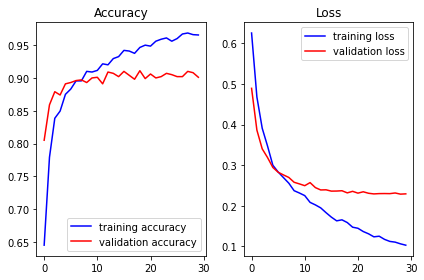

In [14]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
train_loss = history.history['loss']

validation_acc = history.history['val_accuracy']
validation_loss = history.history['val_loss']

fig = plt.figure()
fig_1 = fig.add_subplot(1,2,1)
fig_2 = fig.add_subplot(1,2,2)

fig_1.plot(train_acc, color='b', label='training accuracy')
fig_1.plot(validation_acc, color='r', label='validation accuracy')
fig_1.set_title('Accuracy')
fig_1.legend()

fig_2.plot(train_loss, color='b', label='training loss')
fig_2.plot(validation_loss, color='r', label='validation loss')
fig_2.set_title('Loss')
fig_2.legend()

plt.tight_layout()
plt.show()

## Data Augmentation

In [3]:
import os
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt

# 경로 설정
base_dir = '/content/drive/MyDrive/ML Colab/data/CAT_DOG/cat_dog_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# ImageDataGenerator 생성
# Training Data에 대해서는 데이터 증식 처리
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=40,      # 0~40도 사이의 랜덤한 각도로 이미지 회전
                                   width_shift_range=0.1,  # 10% 내외 랜덤한 비율로 좌우 이동
                                   height_shift_range=0.1, # 10% 내외 랜덤한 비율로 위아래 이동
                                   zoom_range=0.2,         # 20% 내외 랜덤한 비율로 확대 및 축소 
                                   horizontal_flip=True,   # 좌우 반전
                                   vertical_flip=True)     # 위아래 반전 

validation_datagen = ImageDataGenerator(rescale=1/255)

# generator: 데이터 생성 
# for문으로 나중에 ndarray 생성 
train_generator = train_datagen.flow_from_directory(
    train_dir,
    classes=['cats', 'dogs'], 
    target_size=(150,150), # Pretrained Network의 입력 데이터
    batch_size=20,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    classes=['cats', 'dogs'],
    target_size=(150,150), 
    batch_size=20, 
    class_mode='binary'
)

# Pretrained Network
model_base = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

# Pretrained Network에 대한 파라미터 동결
model_base.trainable=False

# DNN 모델
model = Sequential()

# DNN 모델 앞에 추가
model.add(model_base) # Convolution Layer + Pooling Layer

# FC Layer
model.add(Flatten(input_shape=(4*4*512, )))        # Input Layer
model.add(Dense(units=256, activation='relu'))     # Hidden Layer

# Dropout Layer
model.add(Dropout(0.6))

# Output Layer
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

# Optimizer
model.compile(optimizer=RMSprop(learning_rate=2e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Learning
# Numpy Array가 아닌 generator 자체로 학습 
history = model.fit(train_generator, 
                    steps_per_epoch=100,
                    epochs=50, 
                    validation_data=validation_generator,
                    validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/50
100/1

## Check Overfitting

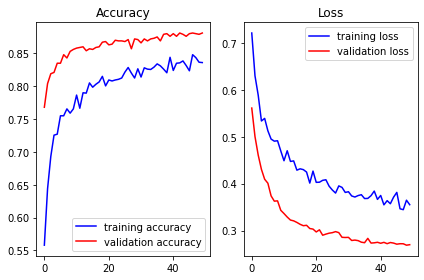

In [4]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

validation_acc = history.history['val_accuracy']
validation_loss = history.history['val_loss']

fig = plt.figure()
fig_1 = fig.add_subplot(1,2,1)
fig_2 = fig.add_subplot(1,2,2)

fig_1.plot(train_acc, color='b', label='training accuracy')
fig_1.plot(validation_acc, color='r', label='validation accuracy')
fig_1.set_title('Accuracy')
fig_1.legend()

fig_2.plot(train_loss, color='b', label='training loss')
fig_2.plot(validation_loss, color='r', label='validation loss')
fig_2.set_title('Loss')
fig_2.legend()

plt.tight_layout()
plt.show()

## 2. Fine Tuning

### First Learning

In [6]:
import os
import numpy as np
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt

# 경로 설정
base_dir = '/content/drive/MyDrive/ML Colab/data/CAT_DOG/cat_dog_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# ImageDataGenerator 생성
# Training Data에 대해서는 데이터 증식 처리
train_datagen = ImageDataGenerator(rescale=1/255,
                                   rotation_range=40,      # 0~40도 사이의 랜덤한 각도로 이미지 회전
                                   width_shift_range=0.1,  # 10% 내외 랜덤한 비율로 좌우 이동
                                   height_shift_range=0.1, # 10% 내외 랜덤한 비율로 위아래 이동
                                   zoom_range=0.2,         # 이미지 확대 및 축소 
                                   horizontal_flip=True,   # 좌우 반전
                                   vertical_flip=True)     # 위아래 반전 

validation_datagen = ImageDataGenerator(rescale=1/255)

# generator: 데이터 생성 
# for문으로 나중에 ndarray 생성 
train_generator = train_datagen.flow_from_directory(
    train_dir,
    classes=['cats', 'dogs'], 
    target_size=(150,150), # Pretrained Network의 입력 데이터
    batch_size=20,
    class_mode='binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    classes=['cats', 'dogs'],
    target_size=(150,150), 
    batch_size=20, 
    class_mode='binary'
)

# Pretrained Network
model_base = VGG16(weights='imagenet', include_top=False, input_shape=(150,150,3))

# Pretrained Network에 대한 파라미터 동결
model_base.trainable=False

# DNN 모델
model = Sequential()

# DNN 모델 앞에 추가
model.add(model_base) # Convolution Layer + Pooling Layer

# FC Layer
model.add(Flatten(input_shape=(4*4*512, )))        # Input Layer
model.add(Dense(units=256, activation='relu'))     # Hidden Layer

# Dropout Layer
model.add(Dropout(0.6))

# Output Layer
model.add(Dense(units=1, activation='sigmoid'))

model.summary()

# Optimizer
model.compile(optimizer=RMSprop(learning_rate=2e-5), loss='binary_crossentropy', metrics=['accuracy'])

# Learning
# Numpy Array가 아닌 generator 자체로 학습 
history = model.fit(train_generator, 
                    steps_per_epoch=100,
                    epochs=50, 
                    validation_data=validation_generator,
                    validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________
Epoch 1/50
100/1

### Second Learning

In [7]:
# 전체 Convolution Layer와 Pooling Layer 레이어 동결 해제
model_base.trainable = True

# 상위 일부(3개) Convolution Layer 동결 해제
for layer in model_base.layers:
    if layer.name in ['block5_conv1','block5_conv2','block5_conv3']:
      layer.trainable = True
    else:
      layer.trainable = False

# Fine Tuning (learning_rate를 더 작게 설정)
model.compile(optimizer=RMSprop(learning_rate=1e-5), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# 재학습
history = model.fit(train_generator, 
                    steps_per_epoch=100,
                    epochs=50, 
                    validation_data=validation_generator,
                    validation_steps=50)

Epoch 1/50
100/100 [==============================] - 23s 226ms/step - loss: 0.3870 - accuracy: 0.8236 - val_loss: 0.2565 - val_accuracy: 0.8780
Epoch 2/50
100/100 [==============================] - 22s 224ms/step - loss: 0.3372 - accuracy: 0.8532 - val_loss: 0.2513 - val_accuracy: 0.8870
Epoch 3/50
100/100 [==============================] - 22s 223ms/step - loss: 0.3182 - accuracy: 0.8663 - val_loss: 0.2507 - val_accuracy: 0.8950
Epoch 4/50
100/100 [==============================] - 23s 229ms/step - loss: 0.3006 - accuracy: 0.8676 - val_loss: 0.2273 - val_accuracy: 0.9030
Epoch 5/50
100/100 [==============================] - 23s 227ms/step - loss: 0.2892 - accuracy: 0.8732 - val_loss: 0.2068 - val_accuracy: 0.9120
Epoch 6/50
100/100 [==============================] - 23s 226ms/step - loss: 0.2770 - accuracy: 0.8735 - val_loss: 0.2520 - val_accuracy: 0.8990
Epoch 7/50
100/100 [==============================] - 23s 227ms/step - loss: 0.2582 - accuracy: 0.8895 - val_loss: 0.2198 - val_ac

## Check Overfitting

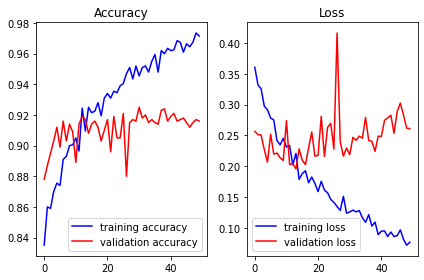

In [8]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

validation_acc = history.history['val_accuracy']
validation_loss = history.history['val_loss']

fig = plt.figure()
fig_1 = fig.add_subplot(1,2,1)
fig_2 = fig.add_subplot(1,2,2)

fig_1.plot(train_acc, color='b', label='training accuracy')
fig_1.plot(validation_acc, color='r', label='validation accuracy')
fig_1.set_title('Accuracy')
fig_1.legend()

fig_2.plot(train_loss, color='b', label='training loss')
fig_2.plot(validation_loss, color='r', label='validation loss')
fig_2.set_title('Loss')
fig_2.legend()

plt.tight_layout()
plt.show()